In [26]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# Create the environment
def create_env():
    return gym.make('FrozenLake-v1', is_slippery=False)  # or True, depending on your use case

# Initialize Q-table
def initialize_q_table(env):
    number_of_states = env.observation_space.n #16, campo 4x4
    number_of_actions = env.action_space.n #4, su,giu,dx,sx
    return np.zeros((number_of_states, number_of_actions))

# Decay function for epsilon
def decay_function(episode, total_train_episodes, min_epsilon, max_epsilon, current_epsilon, decay_type):
    if decay_type == 'linear':
        print("linear")
        tmp = current_epsilon = current_epsilon - (current_epsilon / total_train_episodes)
        return max(min_epsilon,tmp)
    elif decay_type == 'log':
        print("log")
        return max(min_epsilon, min(1.0, 1.0 - np.log10((episode + 1) / (total_train_episodes * 0.1))))
    elif decay_type == 'slow':
        print("slow")
        return 0.99 * current_epsilon

def exploratory_policy(env):
   return np.random.choice(env.action_space.n)


# Choose action based on epsilon-greedy policy (Behavior Policy)
def choose_action(q_table, state, epsilon, env):
    if np.random.random() <= epsilon:
        return env.action_space.sample()  # Exploration
    else:
        return np.argmax(q_table[state])  # Exploitation

# Generate an episode
def generate_episode(epsilon, q_table, env, max_env_steps):
    state = env.reset()
    total_reward = 0
    done = False
    trajectory = []
    
    for step in range(max_env_steps):
        if isinstance(state, tuple):
            state = state[0]

        action = exploratory_policy(env)
        new_state, reward, done, info, _ = env.step(action)
        trajectory.append((state, action, reward))
        state = new_state
        total_reward += reward
        if done:
            break
    
    return trajectory, total_reward

# Calculate P(x) for epsilon-greedy policy
def epsilon_greedy_prob(action, state, q_table, epsilon, env):
    number_of_actions = env.action_space.n
    optimal_action = np.argmax(q_table[state])
    if action == optimal_action:
        return epsilon / number_of_actions + (1.0 - epsilon)
    else:
        return epsilon / number_of_actions

# Every-Visit Monte Carlo con Importanza campionaria
def every_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon, current_epsilon, decay_type):
    q_table = initialize_q_table(env)
    history = np.zeros((total_train_episodes, *q_table.shape))
    epsilons= np.zeros(total_train_episodes)
    visits_counter = np.zeros_like(q_table)
    env.reset()
    max_env_steps = env.spec.max_episode_steps
    
    epsilon = current_epsilon
    for episode in range(total_train_episodes):
        epsilon = decay_function(episode, total_train_episodes, min_epsilon, max_epsilon, epsilon, decay_type)
        trajectory, _ = generate_episode(epsilon, q_table, env, max_env_steps)
        g_mu = 0
        g_pi=1
        w = 1  # Peso iniziale
        
        for t in reversed(range(len(trajectory))):
            state, action, reward = trajectory[t]
            g_mu = gamma * g_mu + reward
            
            # Calculate the importance sampling ratio
            mu_x = 1.0 / env.action_space.n  # Random policy probability
            pi_x = epsilon_greedy_prob(action, state, q_table, epsilon, env)  # Epsilon-greedy probability
            
            w = pi_x / mu_x  # Update weight
            g_pi *= w * g_mu  # Calculate G^\pi_t

            # Q-update using the formula
            visits_counter[state, action] += 1
            q_table[state, action] += (g_pi - q_table[state, action])  

            
            if action != np.argmax(q_table[state]):
                break

        history[episode] = q_table
        epsilons[episode] = epsilon
        
        #print(f"Episode {episode}, epsilon {epsilon:.4f}")
    
    return q_table, history, epsilons


# First-Visit Monte Carlo con Importanza campionaria
def first_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon, current_epsilon, decay_type):
    q_table = initialize_q_table(env)
    returns_count = np.zeros_like(q_table)  # Contatore delle occorrenze
    history = np.zeros((total_train_episodes, *q_table.shape))
    epsilons= np.zeros(total_train_episodes)
    max_env_steps = env.spec.max_episode_steps

    epsilon = current_epsilon
    for episode in range(total_train_episodes):
        epsilon = decay_function(episode, total_train_episodes, min_epsilon, max_epsilon, epsilon, decay_type)  
        #print(f"Episode {episode}, epsilon {epsilon:.4f}")
        trajectory, _ = generate_episode(epsilon, q_table, env, max_env_steps)
        g_mu = 0
        g_pi=1
        w=1  # Peso iniziale
        first_visit_check = set()  # Controllo per la prima visita
        
        for t in reversed(range(len(trajectory))):
            state, action, reward = trajectory[t]
            g_mu = gamma * g_mu + reward
            # Controllo della prima visita
            if (state, action) not in first_visit_check:
                first_visit_check.add((state, action))
                
                # Calculate the importance sampling ratio
                mu_x = 1.0 / env.action_space.n  # Random policy probability
                pi_x = epsilon_greedy_prob(action, state, q_table, epsilon, env)  # Epsilon-greedy probability
                
                w = pi_x / mu_x  # Update weight
                g_pi *= w * g_mu  # Calculate G^\pi_t

                # Q-update using the formula
                q_table[state, action] += (g_pi - q_table[state, action]) 
               
                
            if action != np.argmax(q_table[state]):
                break
        
        history[episode] = q_table
        epsilons[episode] = epsilon
    
    return q_table, history, epsilons






In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Main code
if __name__ == "__main__":
    n_times = 1 #10 is slippery true, 5 otherwise
    total_train_episodes = 1000 #50000 if is slippery true
    gamma = 0.99
    max_epsilon = 1.0
    min_epsilon = 0.01
    current_epsilon = 1.0

    env = create_env()

    # for number in range(n_times):
    #     #print(f"\n ********** Training number {number}")
    #     q_table1, history1, epsilons1 = first_visit_monte_carlo(env, 5000, gamma, max_epsilon, min_epsilon, current_epsilon, "log")
    #     q_table2, history2, epsilons2 = first_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon, current_epsilon, "slow")
    #     q_table3, history3, epsilons3 = first_visit_monte_carlo(env, 5000, gamma, max_epsilon, min_epsilon, current_epsilon, "linear")
        
    # np.save('OFF/models/FV_MC_tables_log.npy', history1)
    # np.save('OFF/models/FV_MC_Q_log.npy', q_table1)
    # np.save('OFF/models/FV_MC_epsilons_log.npy', epsilons1)

 
    # np.save('OFF/models/FV_MC_tables_slow.npy', history2)
    # np.save('OFF/models/FV_MC_Q_slow.npy', q_table2)
    # np.save('OFF/models/FV_MC_epsilons_slow.npy', epsilons2)

        
    # np.save('OFF/models/FV_MC_tables_linear.npy', history3)
    # np.save('OFF/models/FV_MC_Q_linear.npy', q_table3)
    # np.save('OFF/models/FV_MC_epsilons_linear.npy', epsilons3)




    for number in range(n_times):
        #print(f"\n ********** Training number {number}")
        q_table1, history1, epsilons1 = every_visit_monte_carlo(env, 800, gamma, max_epsilon, min_epsilon, current_epsilon, "log")
        q_table2, history2, epsilons2 = every_visit_monte_carlo(env, 1000, gamma, max_epsilon, min_epsilon, current_epsilon, "slow")
        q_table3, history3, epsilons3 = every_visit_monte_carlo(env, 5000, gamma, max_epsilon, min_epsilon, current_epsilon, "linear")
        
    np.save('OFF/models/EV_MC_tables_log.npy', history1)
    np.save('OFF/models/EV_MC_Q_log.npy', q_table1)
    np.save('OFF/models/EV_MC_epsilons_log.npy', epsilons1)

 
    np.save('OFF/models/EV_MC_tables_slow.npy', history2)
    np.save('OFF/models/EV_MC_Q_slow.npy', q_table2)
    np.save('OFF/models/EV_MC_epsilons_slow.npy', epsilons2)

        
    np.save('OFF/models/EV_MC_tables_linear.npy', history3)
    np.save('OFF/models/EV_MC_Q_linear.npy', q_table3)
    np.save('OFF/models/EV_MC_epsilons_linear.npy', epsilons3)

  


log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log
log


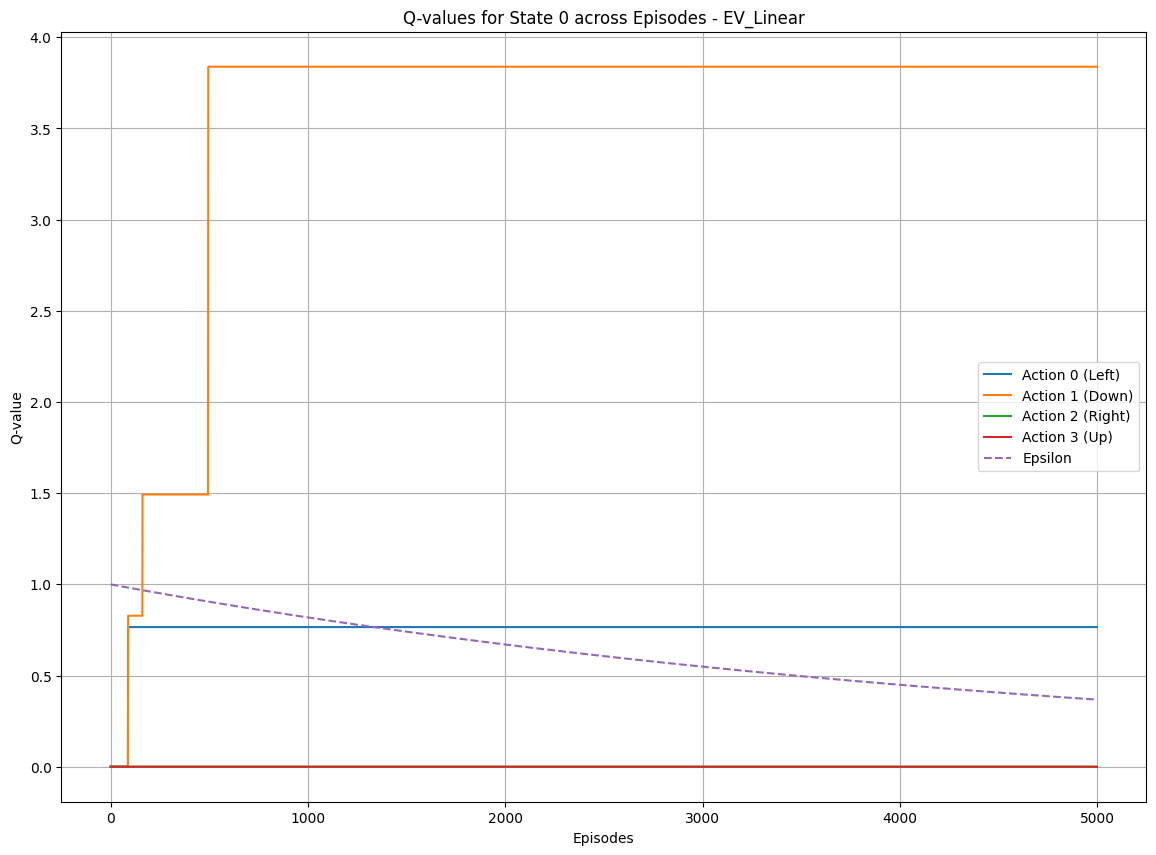

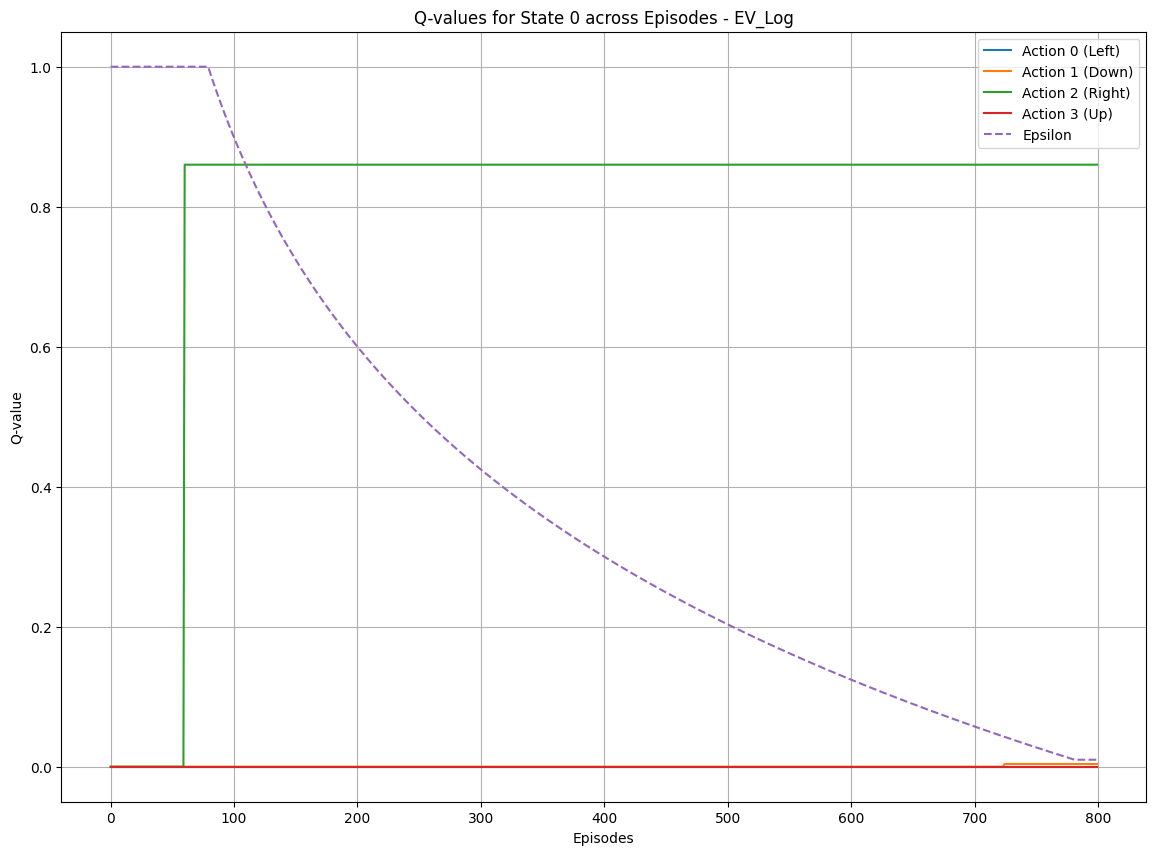

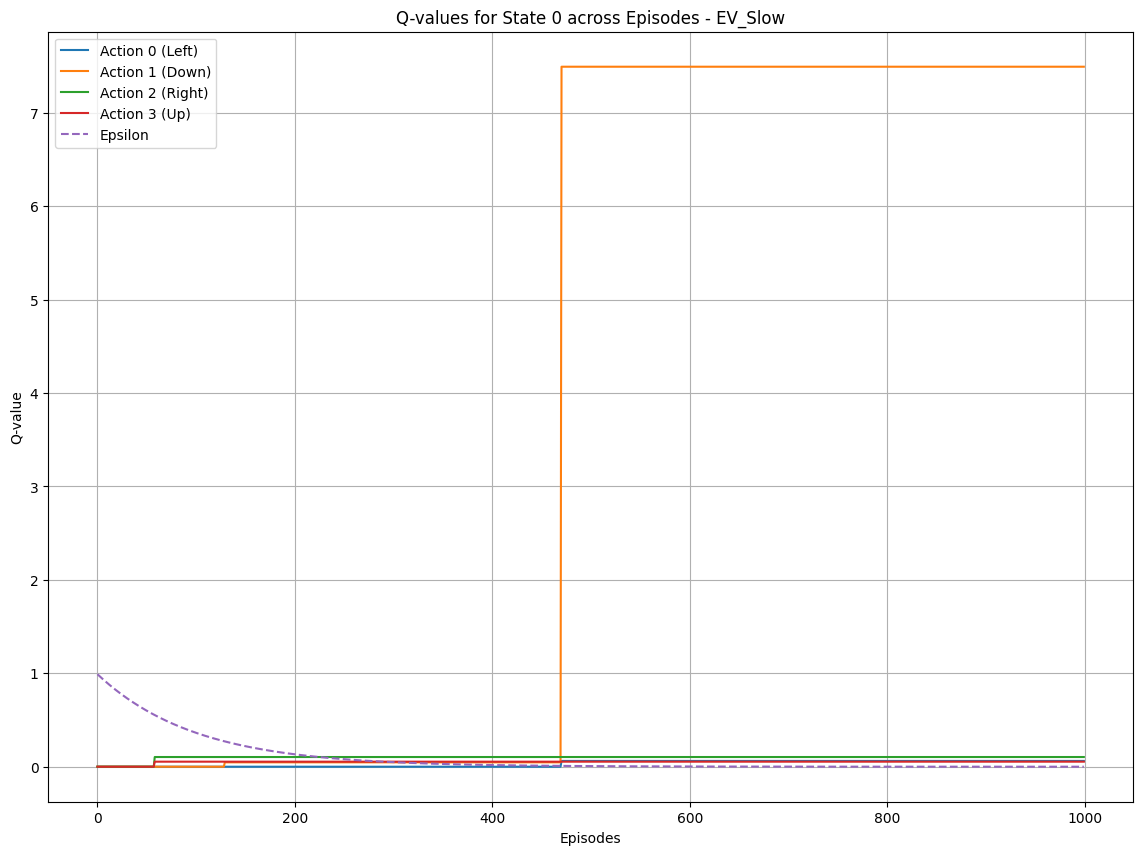

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Load data for different decay functions and learning rates
# Replace with actual file paths and names
data_files = {
    'EV_Linear': {
        'q_values': 'OFF/models/EV_MC_tables_linear.npy',
        'epsilons': 'OFF/models/EV_MC_epsilons_linear.npy'
    },
    'EV_Log': {
        'q_values': 'OFF/models/EV_MC_tables_log.npy',
        'epsilons': 'OFF/models/EV_MC_epsilons_log.npy'
    },
    'EV_Slow': {
        'q_values': 'OFF/models/EV_MC_tables_slow.npy',
        'epsilons': 'OFF/models/EV_MC_epsilons_slow.npy'
    }
}

# Select the state you want to plot
state = 0 # Example: state 0

# Number of actions (assuming 4 actions as in FrozenLake)
num_actions = 4
action_labels = {
    0: 'Left',
    1: 'Down',
    2: 'Right',
    3: 'Up'
}

# Loop through each decay function and generate a separate plot
for label, files in data_files.items():
    history = np.load(files['q_values'])
    epsilons = np.load(files['epsilons'])

    # Create a new figure for each decay function
    plt.figure(figsize=(14, 10))

    # Plot Q-values for each action
    for action in range(num_actions):
        q_values = history[:, state, action]
        plt.plot(q_values, label=f'Action {action} ({action_labels[action]})')

    # Plot epsilon values
    plt.plot(epsilons, label='Epsilon', linestyle='--')

    # Customize and display the plot
    plt.title(f"Q-values for State {state} across Episodes - {label}")
    plt.xlabel('Episodes')
    plt.ylabel('Q-value')
    plt.legend()
    plt.savefig(f'OFF/imgs/{label}_state_{state}.png')
    plt.grid(True)
    plt.show()

# Policy Plot

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

def plot_policy(q_table, grid_size=(4, 4), title='Policy', save_path=None):
    """
    Plots the policy learned by the Q-table on a grid using text labels for directions.

    Parameters:
        q_table (numpy.ndarray): The Q-table from which to derive the policy.
        grid_size (tuple): The size of the grid representing the environment (default is (4, 4)).
    """
    # Define direction labels
    direction_labels = {
        0: '←',  # left
        1: '↓',  # down
        2: '→',  # right
        3: '↑'   # up
    }

  
    policy = np.argmax(q_table, axis=1).reshape(grid_size)
    
    
    # Set up the grid
    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(grid_size[1]))
    ax.set_yticks(np.arange(grid_size[0]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Create grid
    ax.grid(which='both', linestyle='-', linewidth=2)
    
    # Plot direction labels
    i=0
    j=0
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            action = policy[i, j]
            direction = direction_labels[action]
            #print("Cella:",i,j, "Azione", action, "Direzione", direction)
            ax.text(j + 0.5, grid_size[0] - i - 0.5, direction,
                    ha='center', va='center', fontsize=12, color='black')

    # Set the aspect of the plot to equal
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.set_xlim(0, grid_size[1])
    ax.set_ylim(0, grid_size[0])
    #plt.savefig(save_path)
    plt.show()


# Usage example:
if __name__ == "__main__":
    # Assuming you have already saved your Q-tables as 'MC_tables.npy'
    FV_q_table = np.load('OFF/models/FV_MC_Q.npy', allow_pickle=True)
    EV_q_table = np.load('OFF/models/EV_MC_Q.npy', allow_pickle=True)
  
    plot_policy(FV_q_table, title='FV Off Policy', save_path='OFF/imgs/FV_policy.png')
    plot_policy(EV_q_table, title='EV Policy', save_path='OFF/imgs/EV_policy.png')

